# Importowanie bibliotek

In [1]:
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import plotly.graph_objects as go
import scipy.stats as stats
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
pd.set_option('display.max_columns', 10)
pd.set_option('display.width', 200) 

# Ładowanie danych

In [4]:
#file_paths = glob.glob("parquet/dane.parquet")
file_paths = glob.glob("parquet/dane_1_procent.parquet")

df = pd.read_parquet(file_paths, engine="fastparquet")

print(df.head())

                                          block_hash  block_height   timestamp  miner_reward                                               txid  input_value  output_value  fee  size  weight
0  00000000b4c3d5080a57a11ad133ba315a083dd8d867da...         17238  1245077091          50.0  d9f5c7190ebf70b91e808043089c32c5b4c22e4384a769...          0.0          50.0  0.0   135     540
1  00000000e86ab1c182d3c8d6e5b4b29dcf46bc0748a59b...         27721  1258866002          50.0  6e334dc960fdba6d23693fce368e0e75f6a884db8c14a2...          0.0          50.0  0.0   135     540
2  000000000f5ec0f4106f0302f9302cad7da39c5bd7a1e0...          9045  1238285073          50.0  66f51de91d565bb6e607f4e5f7241f40a6c1a6c777043b...          0.0          50.0  0.0   135     540
3  00000000b9b04e2bd8f5b8cb14b84b9d13c04686783a68...         27789  1258924907          50.0  6ebc698c6695cc17d25f635af38e0314c96d738e4ed0ea...          0.0          50.0  0.0   135     540
4  0000000028671e524f9af10d421e9667869b2955e7caf6.

In [4]:
df.shape

(11325203, 10)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11325203 entries, 0 to 11325202
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   block_hash    object 
 1   block_height  int64  
 2   timestamp     int64  
 3   miner_reward  float64
 4   txid          object 
 5   input_value   float64
 6   output_value  float64
 7   fee           float64
 8   size          int64  
 9   weight        int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 864.0+ MB


In [6]:
df.describe()

,block_height,timestamp,miner_reward,input_value,output_value,fee,size,weight
count,1.132520e+07,1.132520e+07,1.132520e+07,1.132520e+07,1.132520e+07,1.132520e+07,1.132520e+07,1.132520e+07
mean,6.342961e+05,1.593034e+09,1.054638e+01,7.668724e+00,7.686208e+00,2.602774e-04,5.501136e+02,1.682431e+03
std,1.714882e+05,9.981879e+07,7.274774e+00,2.299163e+02,2.299170e+02,2.870590e-03,3.114322e+03,8.048516e+03
min,1.940000e+02,1.231748e+09,3.125000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.200000e+01,2.480000e+02
25%,4.997790e+05,1.513513e+09,6.250000e+00,2.921610e-03,2.840750e-03,1.703000e-05,2.230000e+02,5.860000e+02
50%,6.472830e+05,1.599556e+09,6.250000e+00,2.545764e-02,2.543190e-02,6.828000e-05,2.470000e+02,8.920000e+02
75%,7.933540e+05,1.686210e+09,1.250000e+01,3.218520e-01,3.249130e-01,2.000000e-04,3.720000e+02,1.132000e+03
max,8.750000e+05,1.734352e+09,5.000000e+01,1.080110e+05,1.080110e+05,6.300000e+00,8.006830e+05,1.964444e+06


In [5]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')

In [6]:
df['datetime'].min(), df['datetime'].max()

(Timestamp('2009-01-12 08:10:44'), Timestamp('2024-12-16 12:23:18'))

* 5% to (Timestamp('2009-01-09 03:16:28'), Timestamp('2024-12-16 12:23:18'))
* 1% to (Timestamp('2009-01-12 08:10:44'), Timestamp('2024-12-16 12:23:18'))

* Rozmiar danych: zbiór zawiera 56 626 025 wierszy i 10 kolumny
* Dane obejmują okres od 2009-01-09 do 2024-12-16

### Wczytywanie ceny bitcoina

https://www.blockchain.com/explorer/charts/market-price

In [7]:
with open("market-price.json", "r") as f:
    data = json.load(f)

price_list = data["market-price"]  
df_price = pd.DataFrame(price_list)

df_price['datetime'] = pd.to_datetime(df_price['x'], unit='ms')
df_price.rename(columns={'y': 'price'}, inplace=True)

print(df_price.tail())

                  x      price   datetime
1468  1738281600000  104743.97 2025-01-31
1469  1738627200000  101414.76 2025-02-04
1470  1738972800000   96540.70 2025-02-08
1471  1739318400000   95752.00 2025-02-12
1472  1739664000000   97593.62 2025-02-16


# Eksploracyjna analiza danych (eng. EDA) i wizualizacje

### Cena bitcoina w czasie

In [12]:
fig = px.line(
    df_price,
    x='datetime',
    y='price',
    title='Cena Bitcoina w czasie',
    color_discrete_sequence=['skyblue'],
    width=1000,
    height=600 
)

fig.update_xaxes(
    rangeslider_visible=False,
    rangeselector=dict(
        buttons=[
            dict(count=1, label="1M", step="month", stepmode="backward"),
            dict(count=6, label="6M", step="month", stepmode="backward"),
            dict(count=1, label="1Y", step="year", stepmode="backward"),
            dict(count=5, label="5Y", step="year", stepmode="backward"),
            dict(step="all", label="ALL")
        ]
    ),
    title='Data'
)

fig.update_yaxes(title='Cena (USD)')

fig.update_layout(
    title={
        'text': 'Cena Bitcoina w czasie',
        'x': 0.5, 
        'xanchor': 'center'
    },
    paper_bgcolor='white',
    plot_bgcolor='white',
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.show()


### Liczba bloków w czasie

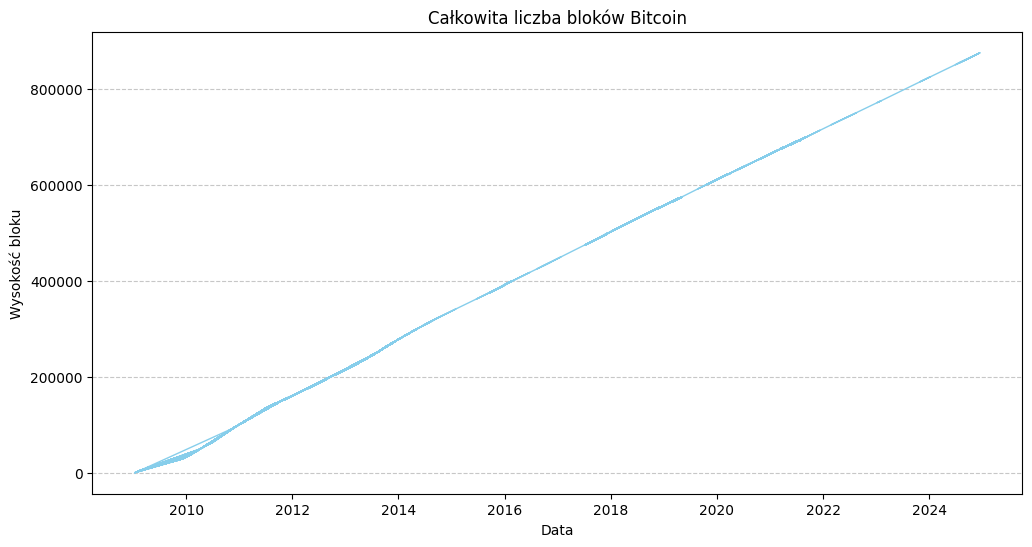

In [11]:
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['block_height'], linewidth=1, color='skyblue')
plt.xlabel("Data")
plt.ylabel("Wysokość bloku")
plt.title("Całkowita liczba bloków Bitcoin")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Nagroda blokowa w czasie

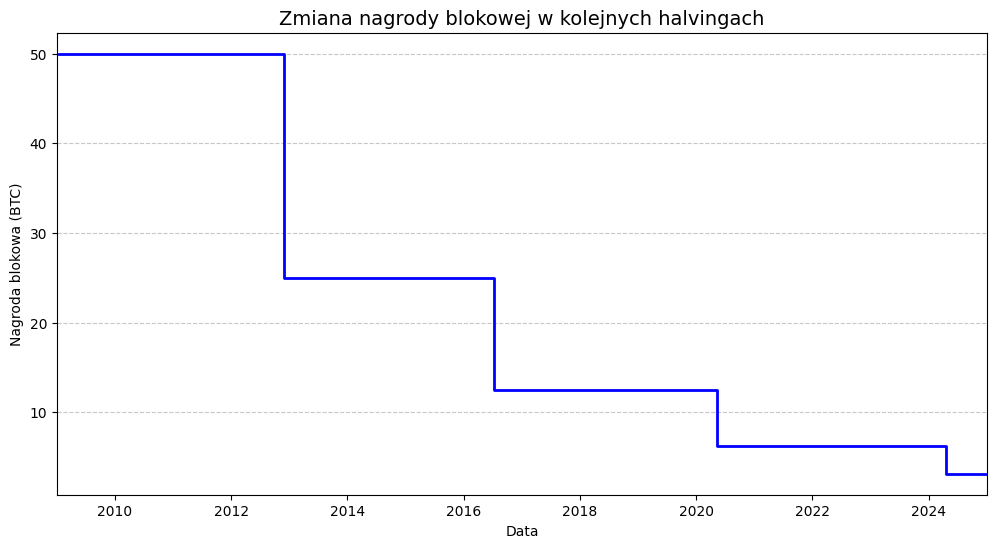

In [12]:
df_temp = df.copy()
df_temp['halving_period'] = df_temp['block_height'] // 210000

grouped = (
    df_temp.groupby('halving_period')
    .agg({'datetime': 'min', 'miner_reward': 'first'})
    .reset_index()
    .sort_values('datetime')
)

last_reward = grouped.iloc[-1]['miner_reward']
extra_date = pd.to_datetime("2024-12-31")

grouped_extra = pd.DataFrame({
    'halving_period': [grouped['halving_period'].max() + 1],
    'datetime': [extra_date],
    'miner_reward': [last_reward]
})
grouped = pd.concat([grouped, grouped_extra], ignore_index=True)
grouped = grouped.sort_values('datetime')

plt.figure(figsize=(12,6))
plt.step(grouped['datetime'], grouped['miner_reward'], where='post', linewidth=2, color='blue')

plt.xlabel("Data")
plt.ylabel("Nagroda blokowa (BTC)")
plt.title("Zmiana nagrody blokowej w kolejnych halvingach", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.xlim(pd.to_datetime("2009-01-01"), pd.to_datetime("2025-01-01"))

plt.show()


### Średnia dzienna opłata transakcyjna (USD) w czasie vs cena Bitcoina

In [8]:
df = df.sort_values('datetime')
df_price = df_price.sort_values('datetime')

df_fee = pd.merge_asof(
    df,
    df_price[['datetime', 'price']],
    on='datetime',
    direction='backward'
)

df_fee['fee_usd'] = df_fee['fee'] * df_fee['price']
df_fee['fee_sat'] = df_fee['fee'] * 100_000_000

df_fee.set_index('datetime', inplace=True)
df_price.set_index('datetime', inplace=True)

weekly_fee_usd = df_fee['fee_usd'].resample('W').mean().reset_index()

weekly_fee_sat = df_fee['fee_sat'].resample('W').mean().reset_index()

weekly_price = df_price['price'].resample('W').mean().reset_index()

In [13]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=weekly_fee_usd['datetime'],
        y=weekly_fee_usd['fee_usd'],
        mode='lines',
        name='Opłata transakcyjna (USD)',
        line=dict(color='green')
    )
)

fig.add_trace(
    go.Scatter(
        x=weekly_price['datetime'],
        y=weekly_price['price'],
        mode='lines',
        name='Cena Bitcoina (USD)',
        line=dict(color='gray'),
        yaxis='y2'
    )
)

fig.update_xaxes(
    rangeslider_visible=False,
    title='Data',
    tickformat='%Y',
    tickmode='linear',
    dtick='M12',
    range=['2009-01-01', '2025-02-12']
)

fig.update_layout(
    title={
        'text': 'Średnia opłata transakcyjna w USD (tygodniowo) vs. Cena Bitcoina (USD)',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='Opłata transakcyjna (USD)',
        showgrid=True,
        gridcolor='lightgray',
        tickprefix='$'
    ),
    yaxis2=dict(
        title='Cena Bitcoina (USD)',
        overlaying='y',
        side='right',
        tickprefix='$'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    width=1600,
    height=600,
    legend=dict(
        x=0,
        xanchor='left',
        y=1,
        yanchor='top'
    )
)

fig.show()

### Średnia dzienna opłata transakcyjna (satoshi) w czasie vs cena Bitcoina

In [15]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=weekly_fee_sat['datetime'],
        y=weekly_fee_sat['fee_sat'],
        mode='lines',
        name='Opłata transakcyjna (satoshi)',
        line=dict(color='orange')  
    )
)

fig.add_trace(
    go.Scatter(
        x=weekly_price['datetime'],
        y=weekly_price['price'],
        mode='lines',
        name='Cena Bitcoina (USD)',
        line=dict(color='gray'),
        yaxis='y2'
    )
)

fig.update_xaxes(
    rangeslider_visible=False,
    title='Data',
    tickformat='%Y',
    tickmode='linear',
    dtick='M12',
    range=['2009-01-01', '2025-02-12']
)

fig.update_layout(
    title={
        'text': 'Średnia opłata transakcyjna w satoshi (tygodniowo) vs. Cena Bitcoina (USD)',
        'x': 0.5,
        'xanchor': 'center'
    },
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='Opłata transakcyjna (satoshi)',
        showgrid=True,
        gridcolor='lightgray'
    ),
    yaxis2=dict(
        title='Cena Bitcoina (USD)',
        overlaying='y',
        side='right',
        tickprefix='$'
    ),
    paper_bgcolor='white',
    plot_bgcolor='white',
    width=1600,
    height=600,
    legend=dict(
        x=0,
        xanchor='left',
        y=1,
        yanchor='top'
    )
)

fig.show()


### Heatmapa korelacji

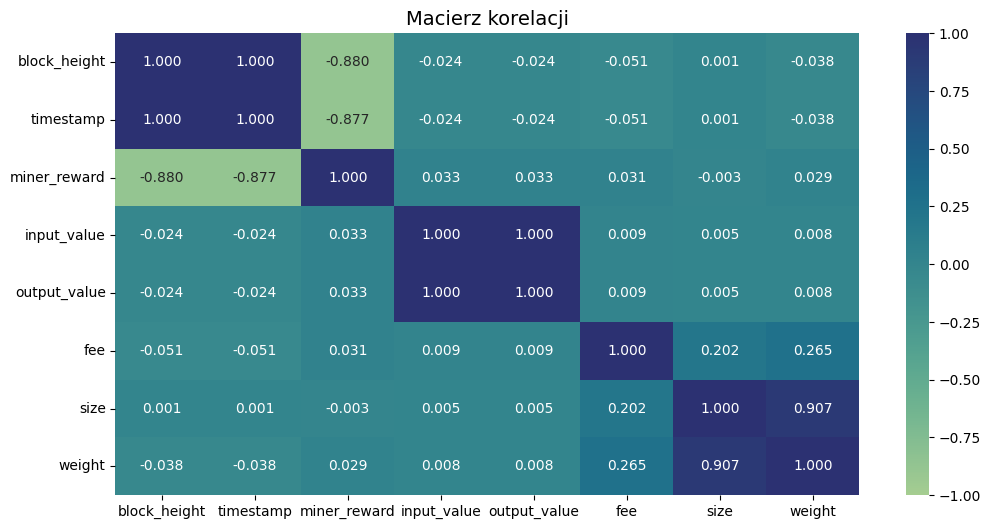

In [18]:
numeric_columns = ['block_height', 'timestamp', 'miner_reward',
                   'input_value', 'output_value', 'fee', 'size', 'weight']

numeric_df = df[numeric_columns]

corr_matrix = numeric_df.corr()

plt.figure(figsize=(12, 6))
sns.heatmap(corr_matrix, annot=True, cmap="crest", fmt='.3f', vmin=-1, vmax=1, center=0)
plt.title('Macierz korelacji', fontsize=14)
plt.show()

# Przetwarzanie danych

### Imputacja brakujących danych numerycznych

In [19]:
df.isna().sum()

block_hash      0
block_height    0
timestamp       0
miner_reward    0
txid            0
input_value     0
output_value    0
fee             0
size            0
weight          0
datetime        0
dtype: int64

Po przeanalizowaniu zbioru danych nie wykryto brakujących wartości w żadnej z kolumn.

### Inżynieria cech


Inżynieria cech pozwala nam wyodrębnić dodatkowe znaczące informacje z istniejącego zbioru danych, co może poprawić dokładność i interpretowalność modeli predykcyjnych.

In [9]:
def add_dateparts(df, col):
    df['Year'] = df[col].dt.year
    df['Month'] = df[col].dt.month
    df['Day'] = df[col].dt.day
    df['DayOfWeek'] = df[col].dt.dayofweek

add_dateparts(df, 'datetime')

In [15]:
print(df.head())

                                            block_hash  block_height   timestamp  miner_reward                                               txid  ...            datetime  Year  Month  Day  \
491  0000000095680bb7be29ad8e6838ccb3eb3af464b813cc...           194  1231747844          50.0  a7edd1f5436d5867b26cbf0bff7663329198b1d4ab41be...  ... 2009-01-12 08:10:44  2009      1   12   
394  00000000f5714fa64e1f16186d5afe7100ca4393320cef...           207  1231757909          50.0  10213d32652ab07be761d88a33ead6a159fa9bc6045684...  ... 2009-01-12 10:58:29  2009      1   12   
232  00000000827d29aff6dd1f65c772885502960a7416957e...           534  1231991091          50.0  ffeb626a814334761798b3c6057d0952926be129c01778...  ... 2009-01-15 03:44:51  2009      1   15   
74   0000000055f9514359114a754ab74471f39a5fe6034ca6...           648  1232067816          50.0  e2ce11cfe4162d88347262841e9cb5f1fa2fa6abd8f9a2...  ... 2009-01-16 01:03:36  2009      1   16   
106  00000000653d00d4e326b0a1776b62ce317

In [16]:
df.columns

Index(['block_hash', 'block_height', 'timestamp', 'miner_reward', 'txid', 'input_value', 'output_value', 'fee', 'size', 'weight', 'datetime', 'Year', 'Month', 'Day', 'DayOfWeek'], dtype='object')

### Treningowy, walidacyjny, i testowy zbiór

Ten krok obejmuje podział zbioru danych na trzy podzbiory:
* Zestaw treningowy: używany do trenowania modelu.
* Zestaw walidacyjny: używany do dostrajania parametrów modelu i unikania nadmiernego dopasowania.
* Zestaw testowy: używany do oceny ostatecznej wydajności modelu na niewidocznych danych.

Oddzielając te podzbiory, zapewniamy, że wydajność modelu jest oceniana na danych, na których nie został przeszkolony, zachowując jego zdolność do generalizacji.

In [10]:
train_df = df[(df['datetime'] >= '2009-01-09') & (df['datetime'] < '2022-01-01')]
val_df   = df[(df['datetime'] >= '2022-01-01') & (df['datetime'] < '2024-01-01')]
test_df  = df[df['datetime'] >= '2024-01-01']

In [11]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (6994111, 15)
val_df.shape : (2464908, 15)
test_df.shape : (1866184, 15)


### Identyfikacja kolumn wejściowych i docelowej

W tym kroku dzielimy zbiór danych na:

* Kolumny wejściowe (cechy): zmienne, które model wykorzysta do tworzenia prognoz.
* Kolumna docelowa: zmienna, którą chcemy przewidzieć, w tym przypadku fee.

In [12]:
input_cols = [col for col in df.select_dtypes(include=['int64', 'int32', 'float64', 'float32']).columns if col not in 'fee']
target_col = 'fee'

In [13]:
train_inputs = train_df[input_cols].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_cols].copy()
val_targets = val_df[target_col].copy()

test_inputs = test_df[input_cols].copy()
test_targets = test_df[target_col].copy()

Zidentyfikujmy również, które z kolumn są liczbowe, a które kategoryczne.

In [14]:
categorical_cols = ['DayOfWeek']
numeric_cols = [col for col in train_inputs.columns if col not in categorical_cols]

### Skalowanie cech numerycznych


Kolejną dobrą praktyką jest skalowanie cech numerycznych do niewielkiego zakresu wartości. Skalowanie zapewnia, że żadna konkretna cecha nie ma nieproporcjonalnego wpływu na straty modelu. W tym projekcie zastosowaliśmy MinMaxScaler, aby znormalizować dane liczbowe w zakresie [0, 1].

In [15]:
scaler = MinMaxScaler().fit(df[numeric_cols])

In [16]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

In [17]:
train_inputs[numeric_cols].describe()

,block_height,timestamp,miner_reward,input_value,output_value,size,weight,Year,Month,Day
count,6.994111e+06,6.994111e+06,6.994111e+06,6.994111e+06,6.994111e+06,6.994111e+06,6.994111e+06,6.994111e+06,6.994111e+06,6.994111e+06
mean,6.007333e-01,5.921875e-01,2.285691e-01,9.083014e-05,9.108054e-05,6.079136e-04,8.392299e-04,5.968578e-01,5.136784e-01,4.896287e-01
std,1.427584e-01,1.424326e-01,1.596619e-01,2.349954e-03,2.349962e-03,3.294394e-03,4.251501e-03,1.512891e-01,3.183207e-01,2.933405e-01
min,0.000000e+00,0.000000e+00,6.666667e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,5.040329e-01,4.947768e-01,2.000000e-01,1.101740e-07,1.091384e-07,2.035920e-04,2.957953e-04,4.666667e-01,2.727273e-01,2.333333e-01
50%,6.243076e-01,6.131111e-01,2.000000e-01,7.406654e-07,7.429745e-07,2.335687e-04,3.339789e-04,6.000000e-01,5.454545e-01,5.000000e-01
75%,7.174722e-01,7.087891e-01,2.000000e-01,6.993728e-06,7.067889e-06,3.896975e-04,6.251922e-04,7.333333e-01,8.181818e-01,7.333333e-01
max,8.189290e-01,8.142540e-01,1.000000e+00,1.000000e+00,1.000000e+00,6.133351e-01,1.000000e+00,8.000000e-01,1.000000e+00,1.000000e+00


### Kodowanie danych kategorycznych

Ponieważ modele uczenia maszynowego można trenować tylko z danymi liczbowymi, musimy przekonwertować zmienne kategorialne na liczby. One-hot encoding polega na utworzeniu nowej kolumny binarnej (0/1) dla każdej unikalnej kategorii w kolumnie kategorialnej. W tym projekcie zastosowaliśmy kodowanie one-hot do kolumny Weekday, aby przedstawić dni tygodnia jako wektory binarne.

In [18]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore').fit(df[categorical_cols])

In [19]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6']


In [20]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

Sprawdzamy, czy dane zostały załadowane prawidłowo

In [21]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (6994111, 18)
train_targets: (6994111,)
val_inputs: (2464908, 18)
val_targets: (2464908,)
test_inputs: (1866184, 18)
test_targets: (1866184,)


In [22]:
train_inputs.columns

Index(['block_height', 'timestamp', 'miner_reward', 'input_value', 'output_value', 'size', 'weight', 'Year', 'Month', 'Day', 'DayOfWeek', 'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3',
       'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6'],
      dtype='object')

# Trenowanie i ocenianie różnych modeli


Na tym etapie stosujemy kilka algorytmów regresji do naszego przetworzonego zbioru danych. Każdy model jest trenowany na zestawie treningowym i oceniany na zestawie walidacyjnym przy użyciu spójnego zestawu wskaźników (RMSE i R²). Porównując te modele, możemy zidentyfikować, które podejścia są najbardziej obiecujące.

In [23]:
def evaluate(model):
    """
    Evaluate the given model on training and validation sets.

    This function uses the trained model to generate predictions for both 
    the training and validation datasets. It then computes the Root Mean Squared Error (RMSE) 
    and R² score for both sets, and returns these metrics in a dictionary.

    Parameters
    ----------
    model : estimator
        A trained scikit-learn estimator that supports the predict method.

    Returns
    -------
    dict
        A dictionary containing:
        - 'train_rmse' : float
            RMSE of the model on the training set.
        - 'train_r2' : float
            R² score of the model on the training set.
        - 'val_rmse' : float
            RMSE of the model on the validation set.
        - 'val_r2' : float
            R² score of the model on the validation set.
    """
    train_preds = model.predict(train_inputs)
    val_preds = model.predict(val_inputs)

    train_rmse = root_mean_squared_error(train_targets, train_preds)
    train_r2 = r2_score(train_targets, train_preds)
    val_rmse = root_mean_squared_error(val_targets, val_preds)
    val_r2 = r2_score(val_targets, val_preds)

    return {
        'train_rmse': round(float(train_rmse), 6),
        'train_r2': round(train_r2, 6),
        'val_rmse': round(float(val_rmse), 6),
        'val_r2': round(val_r2, 6)
    }

### Linear regression


In [24]:
model1 = LinearRegression().fit(train_inputs, train_targets)

In [25]:
result1 = evaluate(model1)

In [27]:
val_preds_lr = model1.predict(val_inputs)

val_df_lr = val_df.copy()

val_df_lr['predicted_fee_lr'] = val_preds_lr
val_df_lr['predicted_fee_sat_lr'] = val_df_lr['predicted_fee_lr'] * 100_000_000 
val_df_lr['fee_sat'] = val_df_lr['fee'] * 100_000_000 


weekly_actual_lr = val_df_lr.resample('W', on='datetime')['fee_sat'].mean().reset_index()
weekly_pred_lr = val_df_lr.resample('W', on='datetime')['predicted_fee_sat_lr'].mean().reset_index()

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_actual_lr['datetime'],
    y=weekly_actual_lr['fee_sat'],
    mode='lines',
    name='Rzeczywista opłata (satoshi)',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=weekly_pred_lr['datetime'],
    y=weekly_pred_lr['predicted_fee_sat_lr'],
    mode='lines',
    name='Prognozowana opłata - Linear Regression',
    line=dict(color='blue')
))

fig.update_layout(
    title='Linear Regression - rzeczywista vs. prognozowana średnia opłata transakcyjna (satoshi)',
    xaxis_title='Data',
    yaxis_title='Opłata transakcyjna (satoshi)',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

### Ridge regression

In [28]:
model2 = Ridge(random_state=42).fit(train_inputs, train_targets)

In [29]:
result2 = evaluate(model2)

In [30]:
val_preds_ridge = model2.predict(val_inputs)

val_df_ridge = val_df.copy()

val_df_ridge['predicted_fee_ridge'] = val_preds_ridge
val_df_ridge['predicted_fee_sat_ridge'] = val_df_ridge['predicted_fee_ridge'] * 100_000_000
val_df_ridge['fee_sat'] = val_df_ridge['fee'] * 100_000_000

weekly_actual_ridge = val_df_ridge.resample('W', on='datetime')['fee_sat'].mean().reset_index()
weekly_pred_ridge = val_df_ridge.resample('W', on='datetime')['predicted_fee_sat_ridge'].mean().reset_index()

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_actual_ridge['datetime'],
    y=weekly_actual_ridge['fee_sat'],
    mode='lines',
    name='Rzeczywista opłata (satoshi)',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=weekly_pred_ridge['datetime'],
    y=weekly_pred_ridge['predicted_fee_sat_ridge'],
    mode='lines',
    name='Prognozowana opłata - Ridge Regression',
    line=dict(color='blue')
))

fig.update_layout(
    title='Ridge Regression - rzeczywista vs. prognozowana średnia opłata transakcyjna (satoshi)',
    xaxis_title='Data',
    yaxis_title='Opłata transakcyjna (satoshi)',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

### ElasticNet

In [31]:
model3 = ElasticNet(random_state=42).fit(train_inputs, train_targets)

In [32]:
result3 = evaluate(model3)

In [33]:
val_preds_elastic = model3.predict(val_inputs)

val_df_elastic = val_df.copy()

val_df_elastic['predicted_fee_elastic'] = val_preds_elastic
val_df_elastic['predicted_fee_sat_elastic'] = val_df_elastic['predicted_fee_elastic'] * 100_000_000
val_df_elastic['fee_sat'] = val_df_elastic['fee'] * 100_000_000

weekly_actual_elastic = val_df_elastic.resample('W', on='datetime')['fee_sat'].mean().reset_index()
weekly_pred_elastic = val_df_elastic.resample('W', on='datetime')['predicted_fee_sat_elastic'].mean().reset_index()

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_actual_elastic['datetime'],
    y=weekly_actual_elastic['fee_sat'],
    mode='lines',
    name='Rzeczywista opłata (satoshi)',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=weekly_pred_elastic['datetime'],
    y=weekly_pred_elastic['predicted_fee_sat_elastic'],
    mode='lines',
    name='Prognozowana opłata - ElasticNet',
    line=dict(color='blue')
))

fig.update_layout(
    title='ElasticNet - rzeczywista vs. prognozowana średnia opłata transakcyjna (satoshi)',
    xaxis_title='Data',
    yaxis_title='Opłata transakcyjna (satoshi)',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

### Decision tree regressor


In [34]:
model4 = DecisionTreeRegressor(max_depth=10, random_state=42).fit(train_inputs, train_targets)

In [35]:
result4 = evaluate(model4)

In [36]:
val_preds_tree = model4.predict(val_inputs)

val_df_tree = val_df.copy()

val_df_tree['predicted_fee_tree'] = val_preds_tree
val_df_tree['predicted_fee_sat_tree'] = val_df_tree['predicted_fee_tree'] * 100_000_000
val_df_tree['fee_sat'] = val_df_tree['fee'] * 100_000_000

weekly_actual_tree = val_df_tree.resample('W', on='datetime')['fee_sat'].mean().reset_index()
weekly_pred_tree = val_df_tree.resample('W', on='datetime')['predicted_fee_sat_tree'].mean().reset_index()

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_actual_tree['datetime'],
    y=weekly_actual_tree['fee_sat'],
    mode='lines',
    name='Rzeczywista opłata (satoshi)',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=weekly_pred_tree['datetime'],
    y=weekly_pred_tree['predicted_fee_sat_tree'],
    mode='lines',
    name='Prognozowana opłata - Decision Tree',
    line=dict(color='blue')
))

fig.update_layout(
    title='Decision Tree - rzeczywista vs. prognozowana średnia opłata transakcyjna (satoshi)',
    xaxis_title='Data',
    yaxis_title='Opłata transakcyjna (satoshi)',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

### Random forest


In [37]:
model5 = RandomForestRegressor(max_depth=10, n_jobs=-1, random_state=42, n_estimators=10).fit(train_inputs, train_targets)

In [38]:
result5 = evaluate(model5)

In [39]:
val_preds_rf = model5.predict(val_inputs)

val_df_rf = val_df.copy()

val_df_rf['predicted_fee_rf'] = val_preds_rf
val_df_rf['predicted_fee_sat_rf'] = val_df_rf['predicted_fee_rf'] * 100_000_000
val_df_rf['fee_sat'] = val_df_rf['fee'] * 100_000_000

weekly_actual_rf = val_df_rf.resample('W', on='datetime')['fee_sat'].mean().reset_index()
weekly_pred_rf = val_df_rf.resample('W', on='datetime')['predicted_fee_sat_rf'].mean().reset_index()

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_actual_rf['datetime'],
    y=weekly_actual_rf['fee_sat'],
    mode='lines',
    name='Rzeczywista opłata (satoshi)',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=weekly_pred_rf['datetime'],
    y=weekly_pred_rf['predicted_fee_sat_rf'],
    mode='lines',
    name='Prognozowana opłata - Random Forest',
    line=dict(color='blue')
))

fig.update_layout(
    title='Random Forest - rzeczywista vs. prognozowana średnia opłata transakcyjna (satoshi)',
    xaxis_title='Data',
    yaxis_title='Opłata transakcyjna (satoshi)',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

### Gradient boosting


In [40]:
model6 = XGBRegressor(random_state=42, n_jobs=-1, objective='reg:squarederror').fit(train_inputs, train_targets)

In [41]:
result6 = evaluate(model6)

In [44]:
val_preds_gb = model6.predict(val_inputs)

val_df_gb = val_df.copy()

val_df_gb['predicted_fee_gb'] = val_preds_gb
val_df_gb['predicted_fee_sat_gb'] = val_df_gb['predicted_fee_gb'] * 100_000_000
val_df_gb['fee_sat'] = val_df_gb['fee'] * 100_000_000

weekly_actual_gb = val_df_gb.resample('W', on='datetime')['fee_sat'].mean().reset_index()
weekly_pred_gb = val_df_gb.resample('W', on='datetime')['predicted_fee_sat_gb'].mean().reset_index()

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_actual_gb['datetime'],
    y=weekly_actual_gb['fee_sat'],
    mode='lines',
    name='Rzeczywista opłata (satoshi)',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=weekly_pred_gb['datetime'],
    y=weekly_pred_gb['predicted_fee_sat_gb'],
    mode='lines',
    name='Prognozowana opłata - Gradient Boosting',
    line=dict(color='blue')
))

fig.update_layout(
    title='Gradient Boosting - rzeczywista vs. prognozowana średnia opłata transakcyjna (satoshi)',
    xaxis_title='Data',
    yaxis_title='Opłata transakcyjna (satoshi)',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

### Wyniki


In [55]:
results = pd.DataFrame(
    data={
        'Linear Regression': result1.values(),
        'Ridge Regression': result2.values(),
        'ElasticNet': result3.values(),
        'Decision Tree Regresor': result4.values(),
        'Random Forest': result5.values(),
        'Gradient Boosting': result6.values()
    },
    index=result1.keys()
)

In [56]:
results

,Linear Regression,Ridge Regression,ElasticNet,Decision Tree Regresor,Random Forest,Gradient Boosting
train_rmse,0.003442,0.003443,0.003606,0.001400,0.001899,0.001630
train_r2,0.088813,0.088491,0.000000,0.849345,0.722785,0.795803
val_rmse,0.000920,0.000909,0.000730,0.000709,0.000676,0.000668
val_r2,-0.783357,-0.742487,-0.124505,-0.059816,0.036486,0.057746


## Dostrajanie hiperparametrów

Dostrajanie hiperparametrów ma na celu optymalizację wydajności modelu poprzez identyfikację najlepszej kombinacji hiperparametrów. W tym kroku skupiamy się na ulepszeniu modelu XGBoost, który wykazał najlepsze wyniki w poprzednich ocenach. Starannie dostosowując parametry, takie jak szybkość uczenia się, liczba estymatorów i głębokość drzewa, staramy się zwiększyć dokładność modelu i zmniejszyć błędy walidacji. Poprzez iteracyjne testowanie i analizę zidentyfikujemy optymalną konfigurację parametrów, która zapewnia najlepszą wydajność predykcyjną.

In [45]:
def test_params(ModelType, **params):
    model = ModelType(**params).fit(train_inputs, train_targets)
    train_rmse = root_mean_squared_error(model.predict(train_inputs), train_targets)
    val_rmse = root_mean_squared_error(model.predict(val_inputs), val_targets)
    return train_rmse, val_rmse

def test_param_and_plot(ModelType, param_name, param_values, **other_params):
    train_errors = []
    val_errors = []
    
    for value in param_values:
        params = dict(other_params)
        params[param_name] = value
        train_rmse, val_rmse = test_params(ModelType, **params)
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)

    plt.figure(figsize=(6,6))
    plt.plot(param_values, train_errors, 'b-o')
    plt.plot(param_values, val_errors, 'r-o')
    plt.title('Overfitting curve: ' + param_name)
    plt.xlabel(param_name)
    plt.ylabel('RMSE')
    plt.legend(['Training', 'Validation'])

Poniżej znajdują się podstawowe hiperparametry dla modelu XGBoost, odziedziczone po naszej poprzedniej konfiguracji o najlepszych wynikach. W miarę postępów będziemy włączać do tego słownika nowo zidentyfikowane optymalne wartości.

In [46]:
standard_params = {
    'random_state': 42,
    'n_jobs': 1,
    'objective': 'reg:squarederror',
    'tree_method': 'gpu_hist'
}

### learning_rate

c:\Users\Hei\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning:

[18:32:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Hei\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning:

[18:32:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Hei\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning:

[18:32:47] WARNING

CPU times: total: 44.5 s
Wall time: 42 s


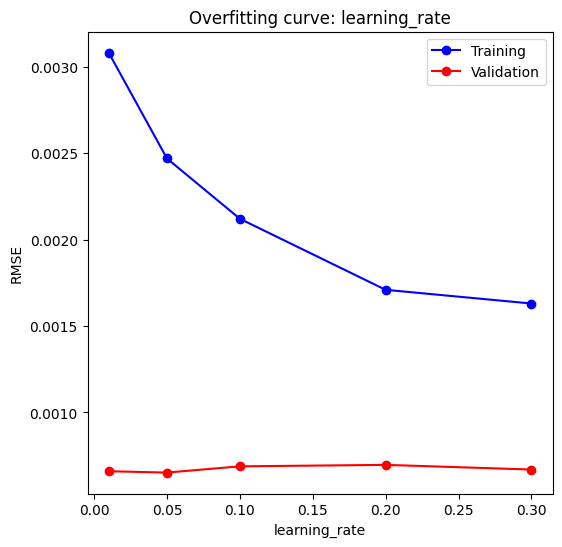

In [47]:
%%time 
test_param_and_plot(XGBRegressor, 'learning_rate', [0.01, 0.05, 0.1, 0.2, 0.3], **standard_params)

In [47]:
standard_params['learning_rate'] = 0.1

### n_estimators

c:\Users\Hei\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning:

[21:29:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Hei\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:2676: UserWarning:

[21:29:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Hei\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py:729: UserWarning:

[21:29:24] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This mi

CPU times: total: 53 s
Wall time: 53.9 s


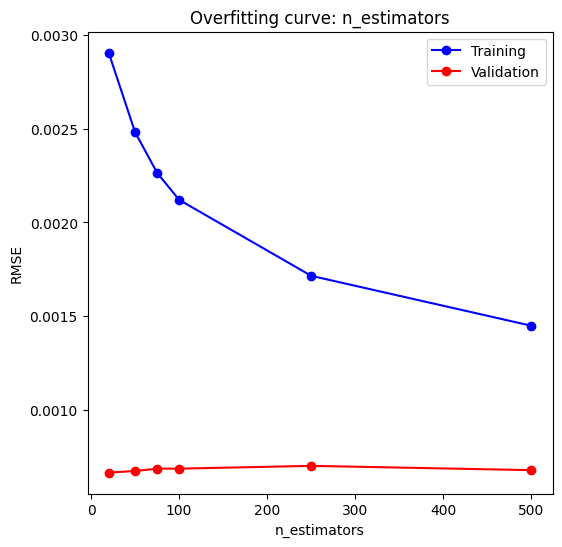

In [48]:
%%time 
test_param_and_plot(XGBRegressor, 'n_estimators', [20, 50, 75, 100, 250, 500], **standard_params)

In [48]:
standard_params['n_estimators'] = 250

### max_depth

c:\Users\Hei\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning:

[12:52:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Hei\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning:

[12:52:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"


c:\Users\Hei\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning:

[12:52:31] WARNING

CPU times: total: 1min 11s
Wall time: 1min 7s


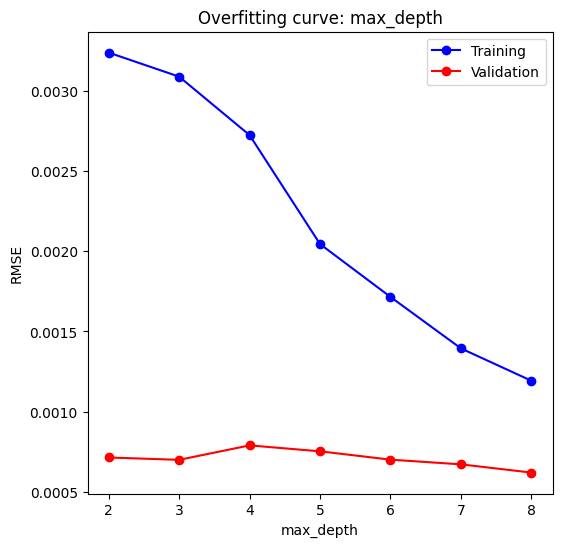

In [61]:
%%time 
test_param_and_plot(XGBRegressor, 'max_depth', [2, 3, 4, 5, 6, 7, 8], **standard_params)

In [49]:
standard_params['max_depth'] = 6

###  wybór hiperparametrów

Wymienione poniżej hiperparametry są wynikiem naszego procesu strojenia krok po kroku. Reprezentują one najlepszą kombinację znalezioną do tej pory, po wielu rundach testowania i udoskonalania.

In [51]:
standard_params

{'random_state': 42,
 'n_jobs': 1,
 'objective': 'reg:squarederror',
 'tree_method': 'gpu_hist',
 'learning_rate': 0.1,
 'n_estimators': 250,
 'max_depth': 6,
 'subsample': 0.8}

In [52]:
model7 = XGBRegressor(**standard_params).fit(train_inputs, train_targets)

C:\Users\danie\AppData\Roaming\Python\Python312\site-packages\xgboost\core.py:158: UserWarning:

[12:29:23] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"




In [72]:
result7 = evaluate(model7)

In [73]:
result7 = pd.DataFrame(
    data={'XGBoost Tuning': result7.values()},
    index=result1.keys()
)

results = pd.concat([results, result7], axis=1)

In [75]:
val_preds_xgb = model7.predict(val_inputs)

val_df_xgb = val_df.copy()

val_df_xgb['predicted_fee_xgb'] = val_preds_xgb
val_df_xgb['predicted_fee_sat_xgb'] = val_df_xgb['predicted_fee_xgb'] * 100_000_000
val_df_xgb['fee_sat'] = val_df_xgb['fee'] * 100_000_000

weekly_actual_xgb = val_df_xgb.resample('W', on='datetime')['fee_sat'].mean().reset_index()
weekly_pred_xgb = val_df_xgb.resample('W', on='datetime')['predicted_fee_sat_xgb'].mean().reset_index()

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_actual_xgb['datetime'],
    y=weekly_actual_xgb['fee_sat'],
    mode='lines',
    name='Rzeczywista opłata (satoshi)',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=weekly_pred_xgb['datetime'],
    y=weekly_pred_xgb['predicted_fee_sat_xgb'],
    mode='lines',
    name='Prognozowana opłata - XGBoost',
    line=dict(color='blue')
))

fig.update_layout(
    title='XGBoost - rzeczywista vs. prognozowana średnia opłata transakcyjna (satoshi)',
    xaxis_title='Data',
    yaxis_title='Opłata transakcyjna (satoshi)',
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()

### GridSearchCV

In [58]:
param_grid = {
    'learning_rate': [0.05, 0.06, 0.07],
    'n_estimators': [330, 350, 400],
    'max_depth': [6, 7],
}

In [59]:
model = XGBRegressor(random_state=42,tree_method ='hist',device='cuda')

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,             
    verbose=2,
    n_jobs=-1
)

In [60]:
grid_search.fit(train_inputs, train_targets)

print("Best params:", grid_search.best_params_)
print("Best score:", -grid_search.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


c:\Users\Hei\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning:


7 fits failed out of a total of 54.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Hei\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Hei\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "c:\Users\Hei\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboos

Best params: {'learning_rate': 0.06, 'max_depth': 6, 'n_estimators': 330}
Best score: 0.0032048514321261225


In [61]:
param_grid = grid_search.best_params_

In [62]:
final = XGBRegressor(random_state=42, **param_grid).fit(train_inputs, train_targets)

In [63]:
result8 = evaluate(final)

In [64]:
result8 = pd.DataFrame(result8.values(), columns=['GridSearchCV'], index=result8.keys())

results = pd.concat([results, result8], axis=1)

### Zbiór tetstowy

In [66]:
test_preds = final.predict(test_inputs)
test_rmse = root_mean_squared_error(test_targets, test_preds)
test_r2 = r2_score(test_targets, test_preds)

print("Test RMSE:", test_rmse)
print("Test R²:", test_r2)

Test RMSE: 0.0006495221424186194
Test R²: 0.2305409589515538


In [ ]:
test_df = test_df.copy()  
test_df['predicted_fee'] = final.predict(test_inputs)

test_df['fee_sat'] = test_df['fee'] * 100_000_000
test_df['predicted_fee_sat'] = test_df['predicted_fee'] * 100_000_000

In [68]:
weekly_actual = test_df.resample('W', on='datetime')['fee_sat'].mean().reset_index()
weekly_pred = test_df.resample('W', on='datetime')['predicted_fee_sat'].mean().reset_index()

In [ ]:
import plotly.graph_objects as go
import locale

locale.setlocale(locale.LC_TIME, 'pl_PL.UTF-8')  

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=weekly_actual['datetime'],
    y=weekly_actual['fee_sat'],
    mode='lines',
    name='Rzeczywista opłata (satoshi)',
    line=dict(color='orange')
))

fig.add_trace(go.Scatter(
    x=weekly_pred['datetime'],
    y=weekly_pred['predicted_fee_sat'],
    mode='lines',
    name='Prognozowana opłata (satoshi)',
    line=dict(color='blue')
))

fig.update_layout(
    title={
        'text': 'Rzeczywista vs. prognozowana średnia opłata transakcyjna (satoshi)',
        'x': 0.5
    },
    xaxis=dict(
        title='Data',
        tickformat='%b %Y',  # np. "sty 2024"
        tickangle=0,
        showgrid=True,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        title='Opłata transakcyjna (satoshi)',
        showgrid=True,
        gridcolor='lightgray'
    ),
    template='plotly_white',
    width=1200,
    height=600
)

fig.show()